In [1]:
import os, logging, warnings, sys
import numpy
import pandas
import timeit

In [2]:
import gensim, pattern
import word2vec
# import vowpalwabbit

/home/agraber/miniconda3/envs/topicmodels/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

* gensim
    * https://rare-technologies.com/deep-learning-with-word2vec-and-gensim/
    * https://rare-technologies.com/word2vec-in-python-part-two-optimizing/
    * https://rare-technologies.com/parallelizing-word2vec-in-python/

* word2vec
    * https://code.google.com/archive/p/word2vec/
    * https://rare-technologies.com/parallelizing-word2vec-in-python/
    
* GloVe 
    * Glove does not work natively with Gensim https://anaconda.org/sbu-hpc/glove
    * https://nlp.stanford.edu/projects/glove/
    * https://github.com/stanfordnlp/GloVe/tree/master/src

* VowpalWabbit https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Tutorial

* StanfordNLP (uses PyTorch) https://stanfordnlp.github.io/stanfordnlp/

Classification
* BigARTM http://docs.bigartm.org/en/stable/intro.html

* https://machinelearningmastery.com/best-practices-document-classification-deep-learning/

* lda2vec (uses Chainer/Keras/PyTorch) https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/
    * https://github.com/cemoody/lda2vec
    * https://github.com/meereeum/lda2vec-tf or
    * https://github.com/nateraw/Lda2vec-Tensorflow

*Scenarios to test*
1. LDA with straight import [pretrained embeddings]
2. LDA with lemmatization (vs stemming vs no manipulation) [pretrained embeddings]
3. LDA with straight import [updated embeddings]
4. LDA with lemmatization (vs stemming vs no manipulation) [updated embeddings]

# Read in CSV
Run Scrape Content first to build csv file

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('assetcrawl.csv', sep='|', header=None, names=['KAS_Name', 'textlength', 'txt'])
df.head()

,KAS_Name,textlength,txt
0,0007e60c-3c57-4f13-b667-55d06d64c38f,6372,today project management pioneer use performan...
1,000f3906-0888-4931-a299-aa53a710634b,2890,organization need product service infrastructu...
2,00163ef8-0338-479e-be56-990a8638b8a4,27442,today world project implement strategy form pe...
3,002a2bb8-5473-40f9-95fa-93adaedf6e7f,6193,involve project management start develop caree...
4,002f1a00-0bc8-4bb2-9c85-66ea563fe095,8220,balance dynamic discipline agility greatest ch...


In [ ]:
df['textlength'].describe()

In [ ]:
df[df['textlength'] < 1000].sort_values(by=['textlength'])

In [ ]:
df[df['textlength'] >10000].sort_values(by=['textlength'])

# Build Corpora & Dictionary 

In [4]:
import os, gensim

In [5]:
# docs is listified text column from assetcrawl df
# keep docs that have text (i.e., no infographic articles)
docs = list(df[df['textlength']>0]['txt'].values)

In [6]:
def tokenize(doc):
    '''
    doc: string of words representing (cleaned) text of a document
    
    returns: list of tokens
    '''
    return [token.encode('utf8') for token in gensim.utils.tokenize(doc, lower=True, errors='ignore')]

In [7]:
# texts is list per doc of tokenized text
texts = [
    tokenize(doc) for doc in docs if type(doc)==str
]

## Filter words by Part-of-Speech
Run if we want to limit input tokens to certain parts of speech

In [168]:
import re, gensim, pattern

allowed_tags=re.compile('(NN)') # re.compile('(NN|VB|JJ|RB|IN)')
# NN: noun
# VB: verb
# JJ: adjective
# RB: adverb
# IN: preposition

filtered_docs = []
for doc in docs:
    parsed = pattern.en.parse(doc, lemmata=False, collapse=False)
    
    filtered = ''
    for sentence in parsed:
        for token, tag, _, _ in sentence:
            if allowed_tags.match(tag):
                filtered += token + ' '
    
    filtered_docs.append(filtered)

In [ ]:
# texts is list per doc of tokenized text
texts = [
    tokenize(doc) for doc in filtered_docs if type(doc)==str
]

## Convert to NLP structures

In [8]:
from gensim import corpora

# build dictionary of tokens (list of all individual tokens seen)
dictionary = corpora.Dictionary(texts)

# build dict of token & index
token2id = dictionary.token2id

# build corpus: for each doc, (token_id, count) pair
corpus = [dictionary.doc2bow(text) for text in texts if len(text)>0]

In [ ]:
# save
path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'
dictionary.save(os.path.join(path,'data/processed/','dictionary.dict'))
corpora.MmCorpus.serialize(os.path.join(path,'data/processed/','corpus.mm'), corpus)

In [9]:
# load
import gensim
path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'
dictionary = gensim.corpora.Dictionary.load(os.path.join(path,'data/processed/','dictionary.dict'))
corpus = gensim.corpora.MmCorpus(os.path.join(path,'data/processed/','corpus.mm'))

/home/agraber/miniconda3/envs/topicmodels/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Look at keyword distributions

In [9]:
key='project'
# tf = []
# for i in range(0,len(corpus)):
#     for t in corpus[i]:
#         try:
#             if token2id[key] in t:
#                 tf.append(t[1])
# #                print('Doc # ' + str(i) + ' has ' + str(t[1]) + ' occurences of the word: ' + key) #[token2id[key]].index(1)
#         except:
#             pass
tf = [t[1] for i in range(0, len(corpus)) for t in corpus[i] if token2id[key] in t ]

import matplotlib.pyplot as plt
plt.hist(tf)
plt.show()

print(f'"{key}" occurs in {len(tf)} documents, or {round(100*len(tf)/len(corpus),1)}% of all articles')

<Figure size 640x480 with 1 Axes>

"project" occurs in 9031 documents, or 98.4% of all articles


## Filter terms with low informational value
TF-IDF weighs a term’s frequency (TF) and its inverse document frequency (IDF).  
The higher the TF-IDF score (weight), the rarer the term and vice versa.
As TF-IDF approaches 0, the term appears frequently in individual documents AND across the corpus, meaning it carries low information for our model.

In [10]:
from gensim import corpora

# build dictionary of tokens (list of all individual tokens seen)
filtered_dict = corpora.Dictionary(texts)

In [11]:
# filter n most frequent terms
filtered_dict.filter_n_most_frequent(remove_n = 20)

# filter tokens that appear only once or appear in >90% of documents
filtered_dict.filter_extremes(no_below = 2,  # no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
                           no_above = 0.9) # no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

filtered_dict.compactify()

In [12]:
# build corpus
filtered_corpus = [filtered_dict.doc2bow(text) for text in texts if len(text)>0]

In [13]:
#identify low value tokens
from gensim.models import TfidfModel
import numpy as np

tfidf = TfidfModel(filtered_corpus, id2word = filtered_dict)
corpus_tfidf = tfidf[filtered_corpus]

threshold = 0.0002 # value between .00015 - .00025
low_value_words = []
for bow in filtered_corpus:
    low_value_words += [id for id, value in tfidf[bow] if value < threshold]
    low_value_words += [id for id, value in tfidf[bow] if ((value is None) | (np.isnan(value)))] # The words with tf-idf socre 0 will be missing
    
[filtered_dict[id] for id in low_value_words]

['month', 'difficult', 'potential', 'ask', 'training']

In [14]:
# filter out low info tokens
filtered_dict.filter_tokens(bad_ids=low_value_words)
filtered_dict.compactify()

In [15]:
# rebuild corpus
filtered_corpus = [filtered_dict.doc2bow(text) for text in texts if len(text)>0]

# Topic Models

## Identify appropriate # topics

LDA is vaguely like Kmeans in that it's unsupervised and we must specify the optimal number of topics.  
Coherence and Perplexity are measures of topic model fit.  


*Topic coherence* is (generally) the sum of pairwise distributional similarity scores over the set of topic words.  'Coherence' is how supportive words of a topic are of each other.  Higher coherence tends to lead to more interpretable topics.  

See (http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) and (https://aclweb.org/anthology/D12-1087) for Coherence measures.

"UCI" Coherence:  
Score calculated by looking at Pointwise Mutual Info (PMI) between 2 words over some *external* corpus.  
The numerator is the probability of co-occurence.  
The denominator is the individual probability of each word occuring.  

"UMass" Coherence:  
Score calculated by considering co-occurence per word pair per document over the *original* training corpus.  
The numerator D(wi,wj) is the number of documents in which words wi and wj appear together. 1 is added to this term because we are taking logs and we need to avoid taking log of 0 when the two words never appear together.  
The denominator is the number of documents D(wi) appears in. So the score is higher if wi and wj appear together in documents a lot relative to how often wi alone appears in documents.  
This makes sense as a measure of topic coherence, since if two words in a topic really belong together you would expect them to show up together a lot. The denominator is just adjusting for the document frequency of the words you are considering, so that words like "the" don't get an artificially high score.

Perplexity: 
used by convention in language modeling, is monotonically decreasing in the likelihood of the test data, and is algebraicly equivalent to the inverse of the geometric mean per-word likelihood. A lower perplexity score indicates better generalization performance.

In [16]:
def make_models(dictionary, corpus, limit, start=2, step=3):
    """
    Develop series of models based on specified number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    """
    from gensim.models import LdaMulticore, CoherenceModel
    import timeit
    
    model_list = []
    
    for num_topics in range(start, limit, step):
        
        start = timeit.default_timer()
        
        # LDA model
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            random_state=100,
            num_topics=num_topics,
            #passes=5,
            alpha='asymmetric',
            eta='auto',
            dtype=np.float64
        )
        model_list.append(model)
               
        stop = timeit.default_timer()
        
        # provide update
        print(f'{num_topics}-topic model completed in {round((stop-start)/60,1)} minutes')
        
    return model_list

In [24]:
def eval_models(model_list, dictionary, ext_corpus, texts):
    """
    Compute c_v and u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    from gensim.test.utils import common_corpus, common_dictionary
    from gensim.models import LdaMulticore, CoherenceModel
    import timeit

    perplexity_list=[]
    c_uci_list = []
    u_mass_list = []    
    
    for model in model_list:
        start = timeit.default_timer()
        # evaluate perplexity
        p = model.log_perplexity(corpus)
        perplexity_list.append(p)
        
        # evaluate coherence
#         For ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary. 
#         For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
        u_mass = CoherenceModel(model=model, corpus=ext_corpus, dictionary=dictionary
           ,coherence='u_mass'
           ,processes=-1
        ).get_coherence()
        c_uci = CoherenceModel(model=model, texts=texts, dictionary=dictionary
            ,coherence='c_uci'
            ,processes=-1
        ).get_coherence()

        u_mass_list.append(u_mass)
        c_uci_list.append(c_uci)
        
        
        stop = timeit.default_timer()
        
        num_topics = len(model.get_topics())
#         print(f'{num_topics}-topic model Perplexity: {round(p,2)}')
#         print(f'{num_topics}-topic model c_uci: {round(c_uci,2)}')
#         print(f'{num_topics}-topic model u_mass: in {round(u_mass,2)}')
#         print(f'{num_topics}-topic model evaluation in {round((stop-start)/60,1)} minutes')
 
    return perplexity_list, u_mass_list, c_uci_list

In [19]:
import gensim
from gensim.models import LdaMulticore, CoherenceModel

min_topics = 10
max_topics = 100 #200
step=10

model_list = make_models(
    dictionary=filtered_dict, corpus=filtered_corpus, 
    start=min_topics, limit=max_topics+step, step=step
)

10-topic model completed in 0.4 minutes
20-topic model completed in 0.4 minutes
30-topic model completed in 0.4 minutes
40-topic model completed in 0.9 minutes
50-topic model completed in 1.6 minutes
60-topic model completed in 2.3 minutes
70-topic model completed in 3.4 minutes
80-topic model completed in 4.2 minutes
90-topic model completed in 5.3 minutes
100-topic model completed in 6.6 minutes


In [ ]:
# save models
import os

path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'

for model in model_list:
    model.save(os.path.join(path,'src','model_'+str(len(model.get_topics()))))

In [ ]:
# load model list
import os
from gensim.models import LdaMulticore

path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'

min_topics = 20
max_topics = 200
step=10

model_list = []
for num_topics in range(min_topics, max_topics+step, step):
    tmp = LdaMulticore.load(os.path.join(path,'src','model_'+str(num_topics)))
    model_list.append(tmp)

In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, CoherenceModel

CoherenceModel(model_list[0], dictionary=dictionary, texts=texts, coherence='c_v').get_coherence()

In [25]:
perplexity_list, u_mass_list, c_uci_list = eval_models(model_list, 
                                                       filtered_dict, 
                                                       wiki_corpus, # filtered_corpus, 
                                                       texts)

10-topic model Perplexity: -7.94
10-topic model c_uci: inf
10-topic model u_mass: in -0.44
10-topic model evaluation in 0.5 minutes
20-topic model Perplexity: -8.0
20-topic model c_uci: inf
20-topic model u_mass: in -0.44
20-topic model evaluation in 0.6 minutes
30-topic model Perplexity: -8.04
30-topic model c_uci: inf
30-topic model u_mass: in -0.46
30-topic model evaluation in 0.6 minutes
40-topic model Perplexity: -8.08
40-topic model c_uci: inf
40-topic model u_mass: in -0.47
40-topic model evaluation in 0.6 minutes
50-topic model Perplexity: -8.03
50-topic model c_uci: inf
50-topic model u_mass: in -0.54
50-topic model evaluation in 0.7 minutes
60-topic model Perplexity: -8.07
60-topic model c_uci: inf
60-topic model u_mass: in -0.52
60-topic model evaluation in 0.7 minutes
70-topic model Perplexity: -8.11
70-topic model c_uci: inf
70-topic model u_mass: in -0.52
70-topic model evaluation in 0.8 minutes
80-topic model Perplexity: -8.15
80-topic model c_uci: inf
80-topic model u_m

In [26]:
num_topics = [len(model.get_topics()) for model in model_list]

In [27]:
# Print the perplexity scores
for num, perp in zip(num_topics, perplexity_list):
    print("Num Topics =", num, " has Log_Perplexity of", round(perp, 4))
    
    # for comparison with sklearn lda perplexity:
    # https://stackoverflow.com/questions/40524768/perplexity-comparision-issue-in-sklearn-lda-vs-gensim-lda
#     [np.exp(-1. * perp) for perp in perplexity_list]

Num Topics = 10  has Log_Perplexity of -7.9445
Num Topics = 20  has Log_Perplexity of -7.9964
Num Topics = 30  has Log_Perplexity of -8.0351
Num Topics = 40  has Log_Perplexity of -8.0801
Num Topics = 50  has Log_Perplexity of -8.0272
Num Topics = 60  has Log_Perplexity of -8.0683
Num Topics = 70  has Log_Perplexity of -8.1093
Num Topics = 80  has Log_Perplexity of -8.1494
Num Topics = 90  has Log_Perplexity of -8.1922
Num Topics = 100  has Log_Perplexity of -8.2319


In [29]:
# Print the u_mass coherence scores
for num, cv in zip(num_topics, u_mass_list):
    print("Num Topics =", num, " has UMass Coherence Value of", round(cv, 4))

Num Topics = 10  has UMass Coherence Value of -0.4397
Num Topics = 20  has UMass Coherence Value of -0.4395
Num Topics = 30  has UMass Coherence Value of -0.4605
Num Topics = 40  has UMass Coherence Value of -0.4739
Num Topics = 50  has UMass Coherence Value of -0.5426
Num Topics = 60  has UMass Coherence Value of -0.524
Num Topics = 70  has UMass Coherence Value of -0.5164
Num Topics = 80  has UMass Coherence Value of -0.5206
Num Topics = 90  has UMass Coherence Value of -0.5328
Num Topics = 100  has UMass Coherence Value of -0.5195


In [28]:
# Print the c_cui coherence scores
for num, cv in zip(num_topics, c_uci_list):
    print("Num Topics =", num, " has c_uci Coherence Value of", round(cv, 4))

Num Topics = 10  has c_uci Coherence Value of inf
Num Topics = 20  has c_uci Coherence Value of inf
Num Topics = 30  has c_uci Coherence Value of inf
Num Topics = 40  has c_uci Coherence Value of inf
Num Topics = 50  has c_uci Coherence Value of inf
Num Topics = 60  has c_uci Coherence Value of inf
Num Topics = 70  has c_uci Coherence Value of inf
Num Topics = 80  has c_uci Coherence Value of inf
Num Topics = 90  has c_uci Coherence Value of inf
Num Topics = 100  has c_uci Coherence Value of inf


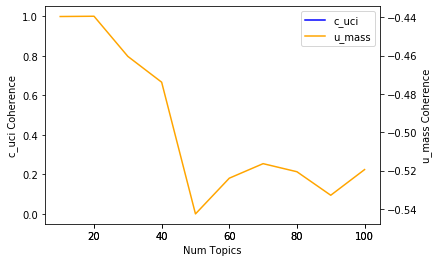

In [30]:
import matplotlib.pyplot as plt

# Plot
fig = plt.figure()

ax1 = fig.add_subplot(111)
line1, = ax1.plot(num_topics, u_mass_list, color='blue')
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("u_mass Coherence")

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
line2, =ax2.plot(num_topics, c_uci_list, color='orange')
ax2.set_ylabel("c_uci Coherence")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

plt.legend([line1, line2],['u_mass','c_uci'], loc='best')
plt.show()

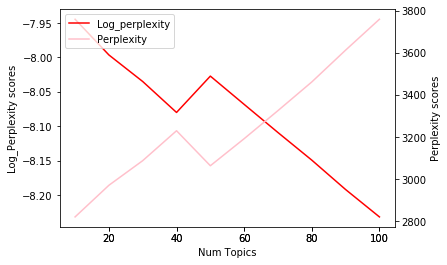

In [31]:
import matplotlib.pyplot as plt

# Plot
fig = plt.figure()

ax1 = fig.add_subplot(111)
line1, = ax1.plot(num_topics, perplexity_list, color='red')
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Log_Perplexity scores")

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
line2, = ax2.plot(num_topics, [np.exp(-1. * perp) for perp in perplexity_list], color='pink')
ax2.set_ylabel("Perplexity scores")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

plt.legend([line1, line2],['Log_perplexity','Perplexity'], loc='best')
plt.show()

# Visualize LDA

In [32]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/home/agraber/miniconda3/envs/topicmodels/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [33]:
# load model
import os
import gensim
#from gensim.test.utils import datapath
from gensim.models import LdaModel, LdaMulticore

path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'

num_topics = 40
#modelpath = datapath(os.path.join(path,'src','model_'+str(num_topics)))
ldamodel = LdaMulticore.load(os.path.join(path,'src','model_'+str(num_topics)))

# filtered_dict = gensim.corpora.Dictionary.load(os.path.join(path,'data/processed/','dictionary.dict'))
# filtered_corpus = gensim.corpora.MmCorpus(os.path.join(path,'data/processed/','corpus.mm'))

/home/agraber/miniconda3/envs/topicmodels/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


* **Saliency**: a measure of how much the term tells you about the topic.
* **Relevance**: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.  

Change the value of λ to adjust the term rankings -- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.

In [34]:
vis = pyLDAvis.gensim.prepare(ldamodel, filtered_corpus, filtered_dict)
start = timeit.default_timer()
vis
stop = timeit.default_timer()
# Change the value of λ to adjust the term rankings -- 
# small values of λ (near 0) highlight potentially rare, 
#   but exclusive terms for the selected topic, and 
# large values of λ (near 1) highlight frequent, 
#   but not necessarily exclusive, terms for the selected topic.

/home/agraber/miniconda3/envs/topicmodels/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23    -0.019020  0.005658       1        1  16.470280
13    -0.015478  0.021919       2        1  14.618007
27    -0.018008  0.009373       3        1   6.645803
15    -0.008768  0.006233       4        1   5.328692
1     -0.013042  0.004162       5        1   5.289379
30    -0.008286 -0.024059       6        1   4.976195
32    -0.017006  0.014549       7        1   4.922104
29    -0.004000 -0.002137       8        1   3.557986
24    -0.011476  0.004544       9        1   3.071107
22    -0.002599 -0.024170      10        1   2.930203
5     -0.012881  0.011428      11        1   2.701873
14    -0.001296  0.003511      12        1   2.445576
16    -0.010500 -0.020100      13        1   2.403161
9     -0.000696  0.004740      14        1   2.309828
35    -0.006673 -0.000998      15        1   2.293216
18    -0.002244  0.011605      16        1   1.971581
2      0.008166  0.003489      17        1   1.751149
39    -0.003208  0.001525      18        1   1.524381
38    -0.000071 -0.002935      19        1   1.400088
7     -0.002742 -0.006189      20        1   1.395220
25    -0.004252  0.002781      21        1   1.333363
10    -0.004165 -0.004610      22        1   1.276289
19     0.001026 -0.008532      23        1   1.113102
20    -0.003454 -0.012057      24        1   1.008597
21    -0.005060  0.006118      25        1   0.974076
6      0.057836  0.017873      26        1   0.967921
17     0.004718  0.003068      27        1   0.945053
3      0.013499 -0.009208      28        1   0.639860
8     -0.007186 -0.001572      29        1   0.577744
37    -0.004296 -0.001247      30        1   0.561793
0      0.008550  0.010873      31        1   0.542358
26    -0.007795 -0.000648      32        1   0.450941
34    -0.007318 -0.003492      33        1   0.448100
4      0.014874  0.008580      34        1   0.253384
33     0.015307 -0.005959      35        1   0.219807
11     0.018564  0.003386      36        1   0.210130
36     0.009704 -0.009719      37        1   0.146936
28     0.026424 -0.012886      38        1   0.122279
31     0.013077 -0.004236      39        1   0.102734
12     0.009775 -0.000660      40        1   0.099704, topic_info=     Category           Freq            Term          Total  loglift  logprob
295   Default  521496.000000         project  521496.000000  30.0000  30.0000
222   Default  165984.000000      management  165984.000000  29.0000  29.0000
368   Default  100544.000000            team  100544.000000  28.0000  28.0000
223   Default   98723.000000         manager   98723.000000  27.0000  27.0000
524   Default   78982.000000    organization   78982.000000  26.0000  26.0000
289   Default   77264.000000         process   77264.000000  25.0000  25.0000
323   Default   59261.000000            risk   59261.000000  24.0000  24.0000
423   Default   53231.000000            work   53231.000000  23.0000  23.0000
374   Default   60557.000000            time   60557.000000  22.0000  22.0000
293   Default   44854.000000         program   44854.000000  21.0000  21.0000
48    Default   45117.000000        business   45117.000000  20.0000  20.0000
450   Default   46753.000000          change   46753.000000  19.0000  19.0000
248   Default   41909.000000             new   41909.000000  18.0000  18.0000
211   Default   38066.000000           level   38066.000000  17.0000  17.0000
81    Default   36530.000000            cost   36530.000000  16.0000  16.0000
267   Default   40223.000000          person   40223.000000  15.0000  15.0000
273   Default   42526.000000            plan   42526.000000  14.0000  14.0000
31    Default   31745.000000            base   31745.000000  13.0000  13.0000
204   Default   34040.000000       knowledge   34040.000000  12.0000  12.0000
62    Default   35861.000000         company   35861.000000  11.0000  11.0000
404   Default   34948.000000           value   3494

In [ ]:
print(f'LDA Viz completed in {round((stop-start)/60,1)} minutes.')

# Build ID/Token/Topic table

In [40]:
path = '/mnt/c/Users/agraber/OneDrive - PMI/Documents/~Projects/TopicModels/'

num_topics = 40
#modelpath = datapath(os.path.join(path,'src','model_'+str(num_topics)))
ldamodel = LdaMulticore.load(os.path.join(path,'src','model_'+str(num_topics)))


doc_topic_probs = [ldamodel.get_document_topics(doc) for doc in filtered_corpus]

[[(1, 0.3148596386469448),
  (2, 0.059469141315795455),
  (13, 0.32742543498877935),
  (14, 0.24020760902046306),
  (16, 0.013968525397376844),
  (23, 0.015019034521959023),
  (25, 0.019712402723399476)],
 [(1, 0.02861803800150454),
  (13, 0.4296851751259713),
  (15, 0.07680972819060375),
  (16, 0.1603243340436633),
  (23, 0.13030151029802714),
  (32, 0.15266960152230652),
  (35, 0.01888351588047007)],
 [(1, 0.1637702799905549),
  (9, 0.06879532483406905),
  (16, 0.22958807498320769),
  (18, 0.019756201563615235),
  (23, 0.4241464735393453),
  (32, 0.04881712370132002),
  (34, 0.012772086999878625)],
 [(1, 0.017189014579760728),
  (7, 0.22542370247059862),
  (10, 0.01613722008693888),
  (13, 0.4412170371977391),
  (23, 0.1586222401024157),
  (30, 0.1010564670447922),
  (32, 0.03715637538862251)],
 [(1, 0.13025231777865565),
  (2, 0.06986748544574807),
  (5, 0.013392176993500756),
  (9, 0.0105991165308123),
  (13, 0.5586230373636856),
  (14, 0.02921126919646474),
  (15, 0.02051191388152

In [ ]:
# Keep highest probability topic AND topics with probability > 0.3

# Predict current hand-coded topics against LDA topic vectors

# Label articles with topic IDs

# Load trained embeddings

## Word2Vec

In [ ]:
from gensim.models import KeyedVectors

filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

## GloVe

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = os.path.join('~/TopicModels/data', 'glove.840B.300d.txt') # input
w2v_file = 'w2v.840B.300d.txt' # output

# _ = glove2word2vec(glove_file, w2v_file)
glove2word2vec(glove_file, w2v_file)

model = KeyedVectors.load_word2vec_format(tmpw2v_file _file)

**Create index maps**

In [ ]:
index_to_word=dict([(x,y) for x,y in enumerate(data)])
word_to_index=dict([(y,x) for x,y in enumerate(data)])

## Retrain embeddings
https://machinelearningmastery.com/develop-word-embeddings-python-gensim/ 

In [ ]:
model - gensim.models.Word2Vec.load('path/to/model')
mode.train(more_sentences)

https://anaconda.org/vkumar1323/gensim_glove_word2vec_example-py/notebook

In [ ]:
from gensim.models import word2vec
from gensim.models import KeyedVectors